# Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/Drive")

base_path = "/content/Drive/My Drive/NLP-Course/04-Semantics-and-Sentiment-Analysis/"

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


# Sentiment Analysis
Now that we've seen word vectors we can start to investigate sentiment analysis. The goal is to find commonalities between documents, with the understanding that similarly *combined* vectors should correspond to similar sentiments.

While the scope of sentiment analysis is very broad, we will focus our work in two ways.

### 1. Polarity classification
We won't try to determine if a sentence is objective or subjective, fact or opinion. Rather, we care only if the text expresses a *positive*, *negative* or *neutral* opinion.
### 2. Document level scope
We'll also try to aggregate all of the sentences in a document or paragraph, to arrive at an overall opinion.
### 3. Coarse analysis
We won't try to perform a fine-grained analysis that would determine the degree of positivity/negativity. That is, we're not trying to guess how many stars a reviewer awarded, just whether the review was positive or negative.

## Broad Steps:
* First, consider the text being analyzed. A model trained on paragraph-long movie reviews might not be effective on tweets. Make sure to use an appropriate model for the task at hand.
* Next, decide the type of analysis to perform. In the previous section on text classification we used a bag-of-words technique that considered only single tokens, or *unigrams*. Some rudimentary sentiment analysis models go one step further, and consider two-word combinations, or *bigrams*. In this section, we'd like to work with complete sentences, and for this we're going to import a trained NLTK lexicon called *VADER*.

## NLTK's VADER module
VADER is an NLTK module that provides sentiment scores based on words used ("completely" boosts a score, while "slightly" reduces it), on capitalization & punctuation ("GREAT!!!" is stronger than "great."), and negations (words like "isn't" and "doesn't" affect the outcome).
<br>To view the source code visit https://www.nltk.org/_modules/nltk/sentiment/vader.html

**Download the VADER lexicon.** You only need to do this once.

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Support Package for SentimentIntensityAnalyzer
!pip install twython 

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

VADER's `SentimentIntensityAnalyzer()` takes in a string and returns a dictionary of scores in each of four categories:
* negative
* neutral
* positive
* compound *(computed by normalizing the scores above)*

In [5]:
from prettytable import PrettyTable

def SentimentPolarityScores(doc):
    # Using polarity_scores function from SentimentIntensityAnalyzer
    polarity_scores = sid.polarity_scores(doc)

    # Displaying the scores in Tabular form
    t = PrettyTable([str(x).capitalize() for x in polarity_scores.keys()])
    t.title = "Sentiment Polarity Scores"
    t.add_row([x for x in polarity_scores.values()])
    print(t)

In [6]:
a = 'This was a good movie.'

SentimentPolarityScores(a)

+--------------------------------+
|   Sentiment Polarity Scores    |
+-----+-------+-------+----------+
| Neg |  Neu  |  Pos  | Compound |
+-----+-------+-------+----------+
| 0.0 | 0.508 | 0.492 |  0.4404  |
+-----+-------+-------+----------+


In [7]:
a = 'This was the best, most awesome movie EVER MADE!!!'

SentimentPolarityScores(a)

+--------------------------------+
|   Sentiment Polarity Scores    |
+-----+-------+-------+----------+
| Neg |  Neu  |  Pos  | Compound |
+-----+-------+-------+----------+
| 0.0 | 0.425 | 0.575 |  0.8877  |
+-----+-------+-------+----------+


In [8]:
a = 'This was the worst film to ever disgraced the screen.'

SentimentPolarityScores(a)

+------------------------------+
|  Sentiment Polarity Scores   |
+------+------+-----+----------+
| Neg  | Neu  | Pos | Compound |
+------+------+-----+----------+
| 0.47 | 0.53 | 0.0 | -0.7964  |
+------+------+-----+----------+


## Use VADER to analyze Amazon Reviews
For this exercise we're going to apply `SentimentIntensityAnalyzer` to a dataset of 10,000 Amazon reviews. Like our movie reviews datasets, these are labeled as either "pos" or "neg". At the end we'll determine the accuracy of our sentiment analysis with VADER.

In [9]:
import numpy as np
import pandas as pd

df = pd.read_csv(base_path + 'amazonreviews.tsv', sep='\t')
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [10]:
df['label'].value_counts()

neg    5097
pos    4903
Name: label, dtype: int64

### Clean the data :

In [11]:
df.isnull().sum()

label     0
review    0
dtype: int64

In [12]:
blanks = []

for index, label, review in df.itertuples():
    if type(review) == str:
        if review.isspace():
            blanks.append(index)

print(len(blanks), "blanks :", blanks)

0 blanks : []


## Let's run the first review through VADER

In [13]:
df.loc[0]['review']

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [14]:
SentimentPolarityScores(df.loc[0]['review'])

+----------------------------------+
|    Sentiment Polarity Scores     |
+-------+-------+-------+----------+
|  Neg  |  Neu  |  Pos  | Compound |
+-------+-------+-------+----------+
| 0.088 | 0.669 | 0.243 |  0.9454  |
+-------+-------+-------+----------+


In [15]:
df.loc[0]['label']

'pos'

Great! Our first review was labeled "positive", and earned a positive compound score.

## Adding Scores and Labels to the DataFrame
In this next section we'll add columns to the original DataFrame to store polarity_score, extracted compound scores, and new "pos/neg" labels derived from the compound score. We'll use this last column to perform an accuracy test.

In [16]:
keys = ["neg", "neu", "pos", "compound"]

for key in keys:
    df[key] = df['review'].apply(lambda review: sid.polarity_scores(review)[key])

df.head()

,label,review,neg,neu,pos,compound
0,pos,Stuning even for the non-gamer: This sound tra...,0.088,0.669,0.243,0.9454
1,pos,The best soundtrack ever to anything.: I'm rea...,0.018,0.837,0.145,0.8957
2,pos,Amazing!: This soundtrack is my favorite music...,0.040,0.692,0.268,0.9858
3,pos,Excellent Soundtrack: I truly like this soundt...,0.090,0.615,0.295,0.9814
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",0.000,0.746,0.254,0.9781


In [17]:
df['predictions'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

df.head()

,label,review,neg,neu,pos,compound,predictions
0,pos,Stuning even for the non-gamer: This sound tra...,0.088,0.669,0.243,0.9454,pos
1,pos,The best soundtrack ever to anything.: I'm rea...,0.018,0.837,0.145,0.8957,pos
2,pos,Amazing!: This soundtrack is my favorite music...,0.040,0.692,0.268,0.9858,pos
3,pos,Excellent Soundtrack: I truly like this soundt...,0.090,0.615,0.295,0.9814,pos
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",0.000,0.746,0.254,0.9781,pos


## Report on Accuracy
Finally, we'll use scikit-learn to determine how close VADER came to our original 10,000 labels.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

def classification_metrics(y_test, y_pred):
    # Calculating the Accuracy Score
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score :", accuracy, "\n\n")

    # Classification Report
    print("Classification Report :\n")
    print(metrics.classification_report(y_test, y_pred), "\n\n")

    # Confusion Matrix
    conf_matx = metrics.confusion_matrix(y_test, y_pred)
    conf_matx_df = pd.DataFrame(conf_matx, index=["True neg", "True pos"], columns=["Predicted neg", "Predicted pos"])
    ## Using Heatmap plot to show the Confusion Matrix
    plt.figure(dpi=80)
    sns.heatmap(conf_matx_df, annot=True, fmt='.0f')
    plt.title("Confuion Matrix - Heatmap", fontdict={"fontsize": 12, "fontweight":"bold"})
    plt.show()

Accuracy Score : 0.7091 


Classification Report :

              precision    recall  f1-score   support

         neg       0.86      0.51      0.64      5097
         pos       0.64      0.91      0.75      4903

    accuracy                           0.71     10000
   macro avg       0.75      0.71      0.70     10000
weighted avg       0.75      0.71      0.70     10000
 




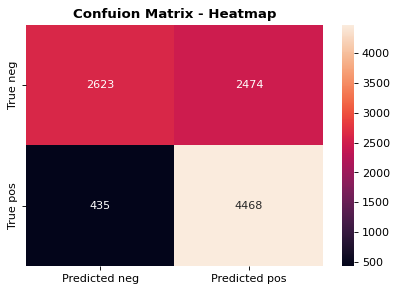

In [19]:
classification_metrics(df["label"], df["predictions"])

This tells us that VADER correctly identified an Amazon review as "positive" or "negative" roughly 71% of the time.